In [35]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys
import os
import snakemake.io as sio
import xarray as xr
sys.path.append(os.path.dirname('../workflow'))
import matplotlib as mpl
from workflow.scripts.plotting_tools import create_facet_plot, global_map

In [118]:
paths = sorted(sio.expand('../results/piClim-2xdust/ERFs/ERFt/ERFt_piClim-2xdust_{models}_Ayear.nc', 
                   models =['EC-Earth3-AerChem','GFDL-ESM4','GISS-E2-1-G','IPSL-CM6A-LR-INCA',
                           'CNRM-ESM2-1','NorESM2-LM','UKESM1-0-LL','MIROC6','MPI-ESM-1-2-HAM']))

mask = xr.open_dataset('../results/masks/dust_regions.nc')


dsets_erf = {}
for path in paths:
    ds = xr.open_dataset(path)
    source_id = ds.source_id
    ds = ds['ERFt'].isel(year=slice(2,None)).mean(dim='year',keep_attrs=True).to_dataset(name=f'{source_id}')
    dsets_erf[source_id]=ds
multi_model_mean = xr.merge(dsets_erf.values()).to_array(dim='model').mean(dim='model')

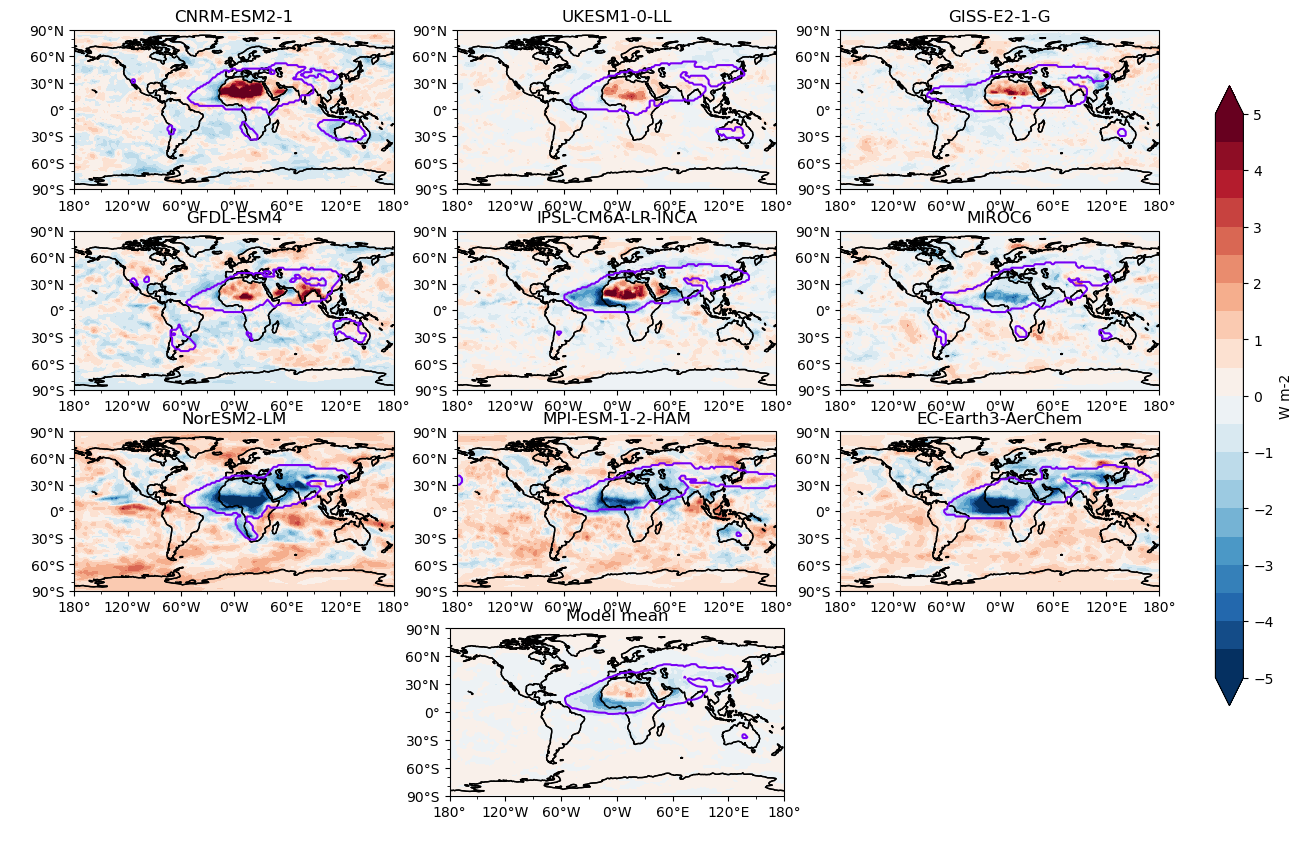

In [123]:
fig = create_facet_plot(len(paths)+1,last_axis_plain=False, create_cax=True, figsize=(14,10))
ax = fig[1]
cax=fig[2]
fig = fig[0]

order = ['CNRM-ESM2-1','UKESM1-0-LL','GISS-E2-1-G','GFDL-ESM4','IPSL-CM6A-LR-INCA','MIROC6',
 'NorESM2-LM','MPI-ESM-1-2-HAM','EC-Earth3-AerChem']

cmap = mpl.colormaps.get('RdBu_r').resampled(20)

norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=5, vmin=-5)
for k, i in zip(ax.keys(), order):
    pfs = dsets_erf[i][i].plot.contourf(ax=ax[k],levels=20,norm=norm,cmap=cmap, add_colorbar=False)
    ax[k].coastlines()
    ax[k].set_title(i)
    global_map(ax[k])
    mask[i].plot.contour(ax=ax[k], levels=1, add_colorbar=False, add_labels=False, colors='#7700F5')
multi_model_mean.plot.contourf(ax=ax['L'],levels=20,norm=norm,cmap=cmap, add_colorbar=False)
global_map(ax['L'])
ax['L'].coastlines()
ax['L'].set_title('Model mean')
mask['mean'].plot.contour(ax=ax['L'], levels=1, add_colorbar=False, add_labels=False, colors='#7700F5')
fig.colorbar(mpl.cm.ScalarMappable(norm,cmap=cmap), cax=cax, extend='both',ticks=[-5,-4,-3,-2,-1,0,1,2,3,4,5], label='W m-2')
plt.savefig('../results/figs/AerChemMIP/map_erf_mask_dusty_non_dusty.pdf')